In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
from torchvision.models import vgg16_bn,VGG16_BN_Weights
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import os
import PIL
from PIL import Image
from torchvision.transforms import Normalize, ToTensor, Compose
from matplotlib import pyplot as plt
import math
import pandas as pd

In [2]:
if torch.cuda.is_available():
    device=torch.device(type="cuda", index=0)
else:
    device=torch.device(type="cpu", index=0)

Image Type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Mask Type: <class 'PIL.GifImagePlugin.GifImageFile'>
Image Size: (565, 584)
Image Shape: (584, 565, 3) Mask Shape: (584, 565)
Unique in Mask: [  0 255]
Image Data Type: uint8
Mask Data Type: uint8


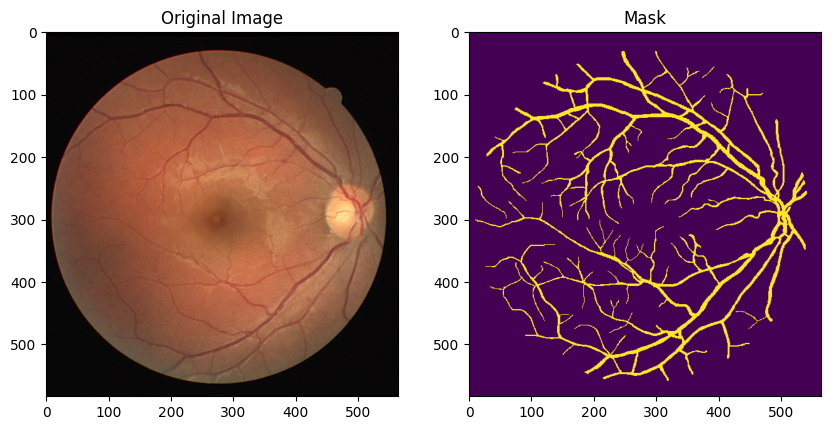

In [9]:
img=Image.open('vessel_segmentation/37_training.tif')
mask=Image.open('vessel_segmentation/37_manual1.gif')
print("Image Type:", type(img))
print("Mask Type:", type(mask))
print("Image Size:",img.size)
print("Image Shape:", np.array(img).shape, "Mask Shape:", np.array(mask).shape)
print("Unique in Mask:",np.unique(mask))
print("Image Data Type:", np.array(img).dtype)
print("Mask Data Type:", np.array(mask).dtype)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask)
plt.show()

In [6]:
def reshape_to_512(imgpath):
    ori_image = Image.open(imgpath)
    reshaped_image=ori_image.resize((512,512),PIL.Image.NEAREST)

    return reshaped_image

After Reshape:
Image Type: <class 'PIL.Image.Image'>
Mask Type: <class 'PIL.Image.Image'>
Image Shape: (512, 512, 3) Mask Shape: (512, 512) Image dtype: uint8 Mask dtype: uint8
Unique in Mask: [  0 255]
Number of Ones in Mask: 30138.0


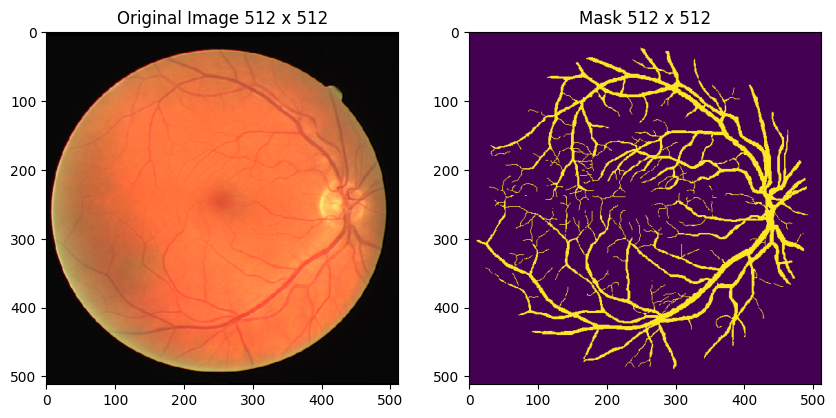

In [8]:
img=reshape_to_512("vessel_segmentation/24_training.tif")
mask=reshape_to_512("vessel_segmentation/24_manual1.gif")

print("After Reshape:")

print("Image Type:", type(img))
print("Mask Type:", type(mask))
print("Image Shape:",np.array(img).shape,"Mask Shape:",np.array(mask).shape,"Image dtype:",np.array(img).dtype,"Mask dtype:", np.array(mask).dtype)
print("Unique in Mask:",np.unique(mask))
print("Number of Ones in Mask:",np.sum(np.sum(np.array(mask)/255)))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image 512 x 512")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Mask 512 x 512")
plt.imshow(mask)
plt.show()

In [ ]:
class TrainDataset(Dataset):
    def __init__(self,path,transform=None):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))
        self.length=int(len(self.filepaths)/2)-4
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return self.length

    def __getitem__(self,idx):
        idx=idx+21
        path=self.path + str(idx) + "_training.tif"
        img=reshape_to_512(path)
        img=self.transform(img)

        path=self.path + str(idx) + "_manual1.gif"
        mask=reshape_to_512(path)
        mask=np.array(mask)
        mask=torch.from_numpy(mask).type(torch.long)
        mask[mask==255]=1

        return img, mask

class ValDataset(Dataset):
    def __init__(self,path,transform=None):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))
        self.length=int(len(self.filepaths)/2)-16
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])


    def __len__(self):
        return self.length

    def __getitem__(self,idx):
        idx=idx+37
        path=self.path + str(idx) + "_training.tif"
        img=reshape_to_512(path)
        img=self.transform(img)

        path=self.path + str(idx) + "_manual1.gif"
        mask=reshape_to_512(path)
        mask=np.array(mask)
        mask=torch.from_numpy(mask).type(torch.long)
        mask[mask==255]=1

        return img, mask

In [ ]:
train_dataset=TrainDataset("drive/My Drive/Deep Learning Eve 2024/sai-vessel-segmentation2/all/train/")
#train_dataset,val_dataset=torch.utils.data.random_split(train_dataset,[16,4])
val_dataset=ValDataset("drive/My Drive/Deep Learning Eve 2024/sai-vessel-segmentation2/all/train/")

batch_size=4

train_dataloader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
val_dataloader=DataLoader(dataset=val_dataset,batch_size=batch_size)

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Image dtype: torch.float32 Mask dtype: torch.int64
Unique in Mask: [0 1]


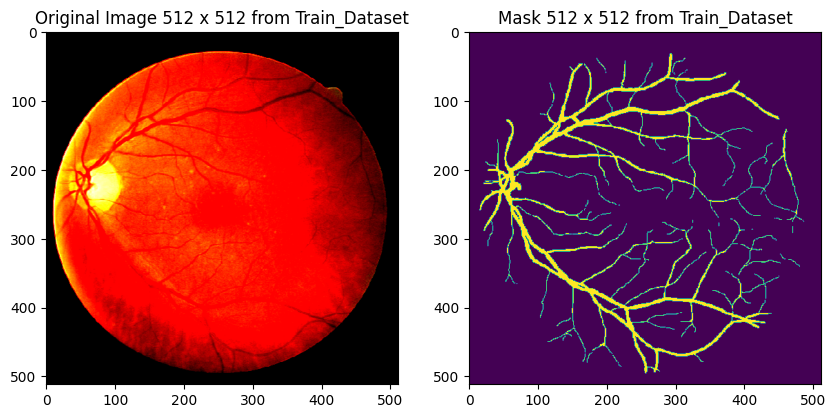

In [ ]:
img,mask=train_dataset[0]

print("Image Shape:",img.shape,"Mask Shape:",mask.shape,"Image dtype:",img.dtype, "Mask dtype:", mask.dtype)
print("Unique in Mask:",np.unique(mask))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image 512 x 512 from Train_Dataset")
plt.imshow(torch.permute(img,(1,2,0)))

plt.subplot(1,2,2)
plt.title("Mask 512 x 512 from Train_Dataset")
plt.imshow(mask)
plt.show()

In [ ]:
class Unet(nn.Module):
    def __init__(self, encoder, center, decoder):
        super().__init__()
        self.encoder=encoder
        self.center=center
        self.decoder=decoder
        #self.dropout=nn.Dropout(p=0.2, inplace=True)

    def forward(self,x):
        encoder_features_outputs=self.encoder(x)
        #self.dropout(encoder_features_outputs[-1])
        center_output=self.center(encoder_features_outputs[-1])
        logits=self.decoder(center_output, encoder_features_outputs)
        return logits

In [ ]:
class Encoder(nn.Module):
    def __init__(self,pretrained_network):
        super().__init__()
        self.encoder=pretrained_network

    def forward(self,x):
        encoder_features_outputs=[]
        for layer in self.encoder.features:
                x=layer(x)
                encoder_features_outputs.append(x)

        return encoder_features_outputs

In [ ]:
class Center(nn.Sequential):
  def __init__(self):
        conv1=nn.Conv2d(in_channels=512,out_channels=1024, kernel_size=3,padding=1)
        bn1=nn.BatchNorm2d(num_features=1024)
        rl1=nn.ReLU()

        conv2=nn.Conv2d(in_channels=1024,out_channels=1024, kernel_size=3,padding=1)
        bn2=nn.BatchNorm2d(num_features=1024)
        rl2=nn.ReLU()

        super().__init__(conv1,bn1,rl1,conv2,bn2,rl2)

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.rl=nn.ReLU()

        self.conv5_up=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.conv5_1=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.bn5_1=nn.BatchNorm2d(num_features=512)
        self.conv5_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_2=nn.BatchNorm2d(num_features=512)
        self.conv5_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_3=nn.BatchNorm2d(num_features=512)

        self.conv4_up=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.conv4_1=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.bn4_1=nn.BatchNorm2d(num_features=512)
        self.conv4_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_2=nn.BatchNorm2d(num_features=512)
        self.conv4_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_3=nn.BatchNorm2d(num_features=512)

        self.conv3_up=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.conv3_1=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.bn3_1=nn.BatchNorm2d(num_features=256)
        self.conv3_2=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_2=nn.BatchNorm2d(num_features=256)
        self.conv3_3=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_3=nn.BatchNorm2d(num_features=256)

        self.conv2_up=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.conv2_1=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.bn2_1=nn.BatchNorm2d(num_features=128)
        self.conv2_2=nn.Conv2d(in_channels=128,out_channels=128, kernel_size=3,padding=1)
        self.bn2_2=nn.BatchNorm2d(num_features=128)

        self.conv1_up=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.conv1_1=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.bn1_1=nn.BatchNorm2d(num_features=64)
        self.conv1_2=nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3,padding=1)
        self.bn1_2=nn.BatchNorm2d(num_features=64)

        self.convfinal=nn.Conv2d(in_channels=64,out_channels=2,kernel_size=1)

    def forward(self,x, encoder_features_output):
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv5_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[42]),dim=1)
        x=self.conv5_1(x)
        x=self.bn5_1(x)
        x=self.rl(x)
        x=self.conv5_2(x)
        x=self.bn5_2(x)
        x=self.rl(x)
        x=self.conv5_3(x)
        x=self.bn5_3(x)
        x=self.rl(x)

        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv4_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[32]),dim=1)
        x=self.conv4_1(x)
        x=self.bn4_1(x)
        x=self.rl(x)
        x=self.conv4_2(x)
        x=self.bn4_2(x)
        x=self.rl(x)
        x=self.conv4_3(x)
        x=self.bn4_3(x)
        x=self.rl(x)

        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv3_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[22]),dim=1)
        x=self.conv3_1(x)
        x=self.bn3_1(x)
        x=self.rl(x)
        x=self.conv3_2(x)
        x=self.bn3_2(x)
        x=self.rl(x)
        x=self.conv3_3(x)
        x=self.bn3_3(x)
        x=self.rl(x)

        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv2_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[12]),dim=1)
        x=self.conv2_1(x)
        x=self.bn2_1(x)
        x=self.rl(x)
        x=self.conv2_2(x)
        x=self.bn2_2(x)
        x=self.rl(x)

        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv1_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[5]),dim=1)
        x=self.conv1_1(x)
        x=self.bn1_1(x)
        x=self.rl(x)
        x=self.conv1_2(x)
        x=self.bn1_2(x)
        x=self.rl(x)

        logits=self.convfinal(x)

        return logits

In [ ]:
def train_one_epoch(dataloader, model,loss_fn, optimizer):
    model.train()
    track_loss=0
    XintY=0
    X=0
    Y=0
    for i, (imgs, masks) in enumerate(dataloader):
        imgs=imgs.to(device)
        masks=masks.to(device)

        preds=model(imgs)

        loss=loss_fn(preds,masks)

        track_loss+=loss.item()

        predclass=torch.argmax(preds,dim=1)

        Y+=predclass.sum().item()
        X+=masks.sum().item()


        predclass[predclass==0]=2

        XintY+=(predclass==masks).type(torch.float).sum().item()

        print("Trainig Batch",i+1,":","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss=round(track_loss/(i+1),2)
        running_dice_coef=round(((2*XintY)/(X+Y)),2)

        print("Training Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)

    epoch_loss=running_loss
    epoch_dice_coef=running_dice_coef
    return epoch_loss, epoch_dice_coef


def val_one_epoch(dataloader, model,loss_fn):
    model.eval()
    track_loss=0
    XintY=0
    X=0
    Y=0
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(dataloader):
            imgs=imgs.to(device)
            masks=masks.to(device)

            preds=model(imgs)

            loss=loss_fn(preds,masks)

            track_loss+=loss.item()

            predclass=torch.argmax(preds,dim=1)

            Y+=predclass.sum().item()
            X+=masks.sum().item()

            predclass[predclass==0]=2

            XintY+=(predclass==masks).type(torch.float).sum().item()

            print("Validation Batch",i+1,":","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)


            running_loss=round(track_loss/(i+1),2)
            running_dice_coef=round(((2*XintY)/(X+Y)),2)

            print("Validation Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)

    epoch_loss=running_loss
    epoch_dice_coef=running_dice_coef
    return epoch_loss, epoch_dice_coef

In [ ]:
pretrained_network=vgg16_bn(weights=VGG16_BN_Weights.DEFAULT)
print(pretrained_network)

for param in pretrained_network.features.parameters():
    param.requires_grad=False

encoder=Encoder(pretrained_network).to(device)
center=Center().to(device)
decoder=Decoder().to(device)

model=Unet(encoder,center, decoder).to(device)

loss_fn=nn.CrossEntropyLoss()
lr=0.001
optimizer=torch.optim.Adam(params=model.parameters(), lr=lr)
n_epochs=2

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    val_epoch_loss, val_epoch_dice_coef=val_one_epoch(val_dataloader,model,loss_fn)
    print("Validation Epoch Loss:", val_epoch_loss, "Validation Epoch Dice_Coef:", val_epoch_dice_coef)
    print("--------------------------------------------------")


for param in pretrained_network.features.parameters():
    param.requires_grad=True

n_epochs=2
for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    val_epoch_loss, val_epoch_dice_coef=val_one_epoch(val_dataloader,model,loss_fn)
    print("Validation Epoch Loss:", val_epoch_loss, "Validation Epoch Dice_Coef:", val_epoch_dice_coef)
    print("--------------------------------------------------")

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:08<00:00, 61.6MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
def plotres(img,pred,mask=None):
    img[0,:,:]=img[0,:,:]*0.229 + 0.485
    img[1,:,:]=img[1,:,:]*0.224 + 0.456
    img[2,:,:]=img[2,:,:]*0.225 + 0.406
    if mask!=None:
        print("Image Shape:",img.shape,"Mask Shape:", mask.shape, "Pred Shape:",pred.shape, "Image dtype", img.dtype, "Mask dtype",mask.dtype, "Pred dtype",pred.dtype)
        print("Mask Unique:",mask.unique())
    else:
        print("Image Shape:",img.shape, "Pred Shape:", pred.shape, "Image dtype:",img.dtype, "Pred dtype:",pred.dtype)

    print("Pred Unique:",pred.unique())

    plt.figure(figsize=(10,5))

    plt.subplot(1,3,1)
    plt.title("Original Image 512 x 512")
    plt.imshow(torch.permute(img.cpu(),(1,2,0)))

    if mask!=None:
        plt.subplot(1,3,2)
        plt.title("Mask Image  512 x 512")
        plt.imshow(mask.cpu())

    plt.subplot(1,3,3)
    plt.title("Predicted Image  512 x 512")
    plt.imshow(pred.cpu())
    plt.show()

On Validation Set: 2*XintY: 28714.0 X: 88013 Y: 27046 X+Y: 115059
Validation Dice Coef: 0.25
Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


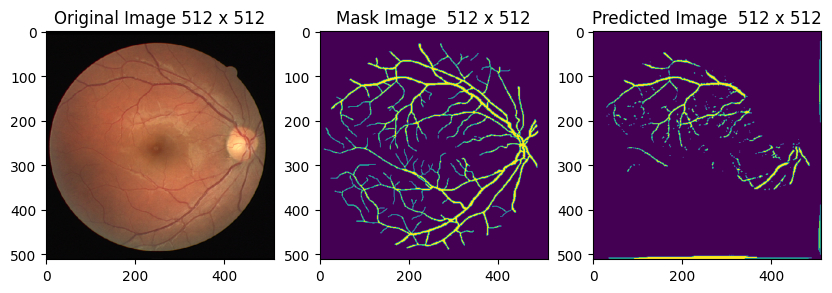

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


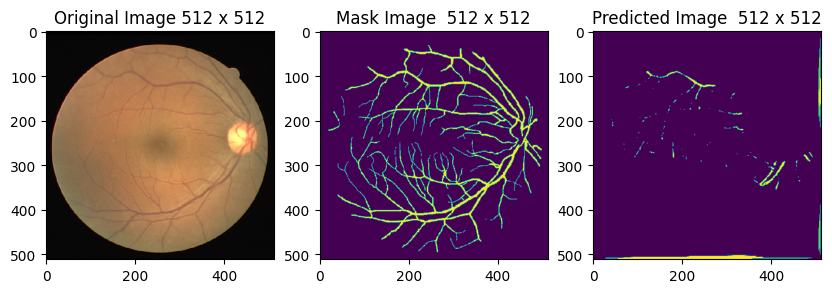

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


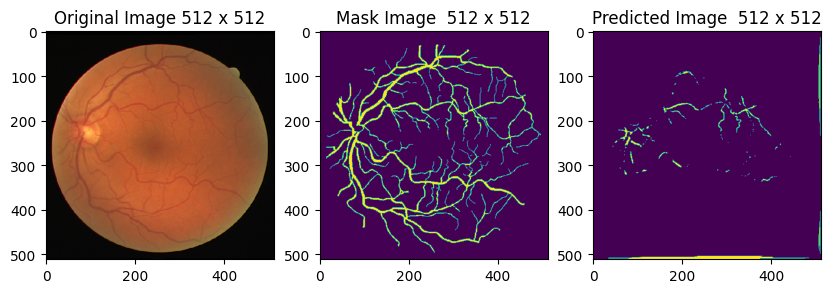

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


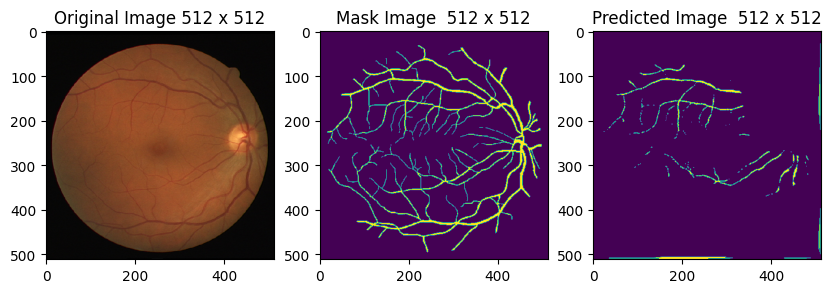

In [ ]:
imgs,masks=next(iter(val_dataloader))
model.eval()

imgs=imgs.to(device)
masks=masks.to(device)

with torch.no_grad():
    preds=model(imgs)

    predclass=torch.argmax(preds,dim=1)

    Y=predclass.sum().item()
    X=masks.sum().item()

    predclass[predclass==0]=2

    XintY=(predclass==masks).type(torch.float).sum().item()

    print("On Validation Set:","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)

    dice_coef=round((2*XintY)/(X+Y),2)


print("Validation Dice Coef:",dice_coef)

predclass[predclass==2]=0
plotres(imgs[0],predclass[0],masks[0])
plotres(imgs[1],predclass[1],masks[1])
plotres(imgs[2],predclass[2],masks[2])
plotres(imgs[3],predclass[3],masks[3])

In [ ]:
train_dataset=TrainDataset("vessel_segmentation/", "yes")

batch_size=4

n_epochs=2

train_dataloader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    print("--------------------------------------------------")

Epoch No: 1
Trainig Batch 1 : 2*XintY: 139354.0 X: 94858 Y: 87296 X+Y: 182154
Training Batch 1 : / 4 Running Loss: 0.17 Running Dice_Coef: 0.77
Trainig Batch 2 : 2*XintY: 276230.0 X: 189583 Y: 176726 X+Y: 366309
Training Batch 2 : / 4 Running Loss: 0.17 Running Dice_Coef: 0.75
Trainig Batch 3 : 2*XintY: 398428.0 X: 283197 Y: 256809 X+Y: 540006
Training Batch 3 : / 4 Running Loss: 0.17 Running Dice_Coef: 0.74
Trainig Batch 4 : 2*XintY: 505408.0 X: 364581 Y: 327177 X+Y: 691758
Training Batch 4 : / 4 Running Loss: 0.17 Running Dice_Coef: 0.73
Training Epoch Loss: 0.17 Training Epoch Dice_Coef: 0.73
--------------------------------------------------
Epoch No: 2
Trainig Batch 1 : 2*XintY: 116494.0 X: 86786 Y: 72556 X+Y: 159342
Training Batch 1 : / 4 Running Loss: 0.16 Running Dice_Coef: 0.73
Trainig Batch 2 : 2*XintY: 253252.0 X: 182478 Y: 156451 X+Y: 338929
Training Batch 2 : / 4 Running Loss: 0.16 Running Dice_Coef: 0.75
Trainig Batch 3 : 2*XintY: 390372.0 X: 277774 Y: 241240 X+Y: 519014


In [ ]:
class TestDataset(Dataset):
    def __init__(self,path):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))
        self.length=len(self.filepaths)
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return self.length

    def __getitem__(self,idx):
        idx=idx+1
        if idx <= 9:
            path=self.path + "0" + str(idx) + "_test.tif"
        else:
            path=self.path + str(idx) + "_test.tif"

        img=reshape_to_512(path)
        img=self.transform(img)

        return img

In [ ]:
torch.cuda.empty_cache()

In [ ]:
test_dataset=TestDataset("vessel_segmentation_test/")

batch_size=2
test_dataloader=DataLoader(dataset=test_dataset,batch_size=batch_size)

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


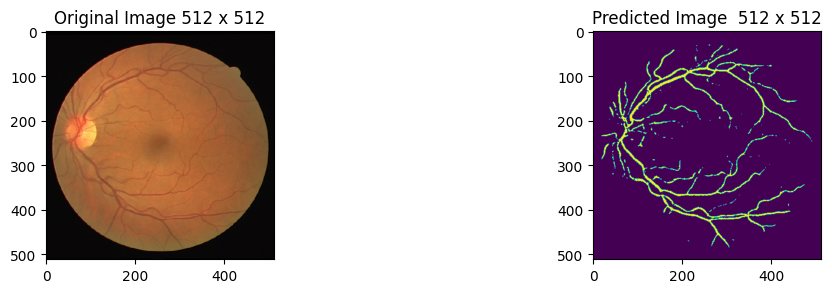

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


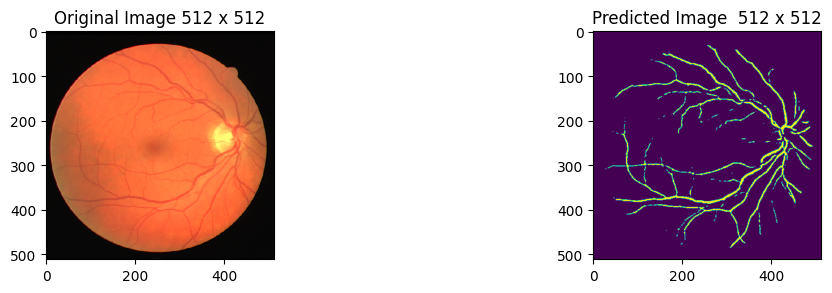

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


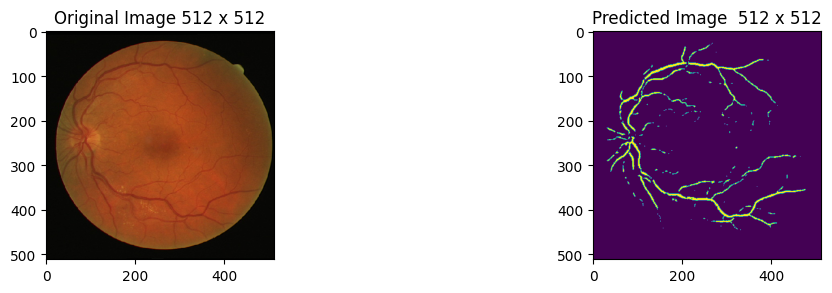

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


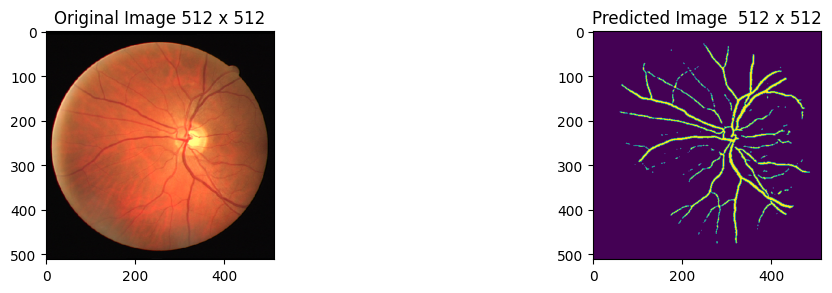

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


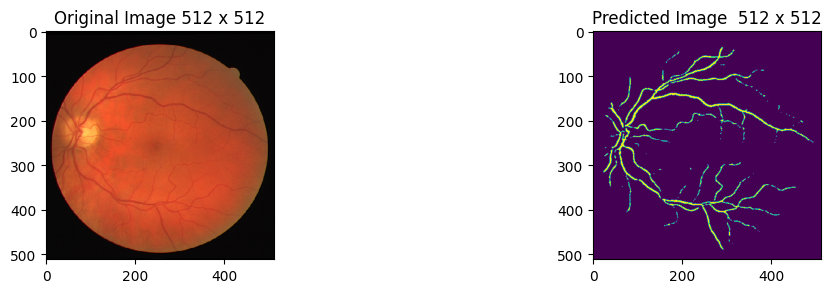

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


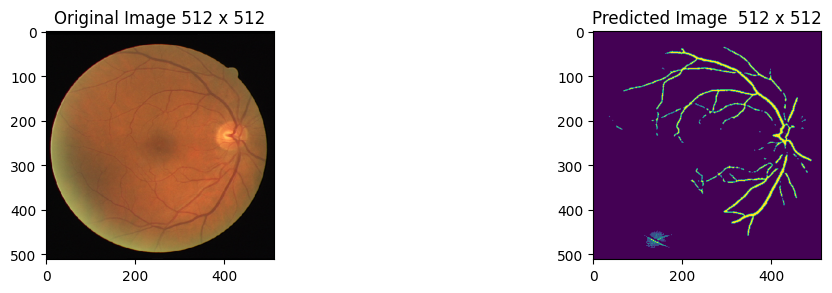

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


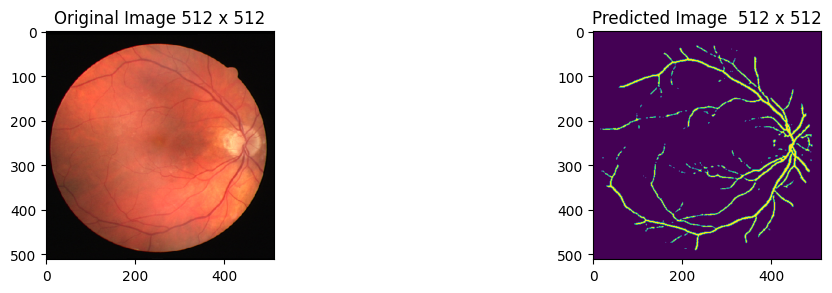

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


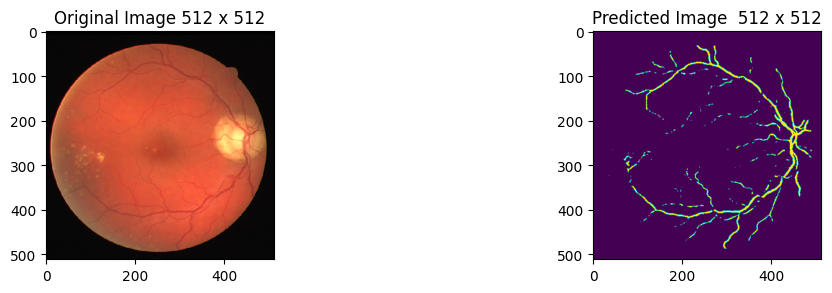

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


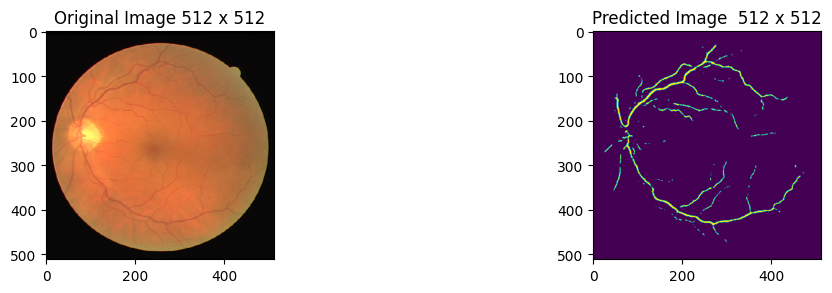

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


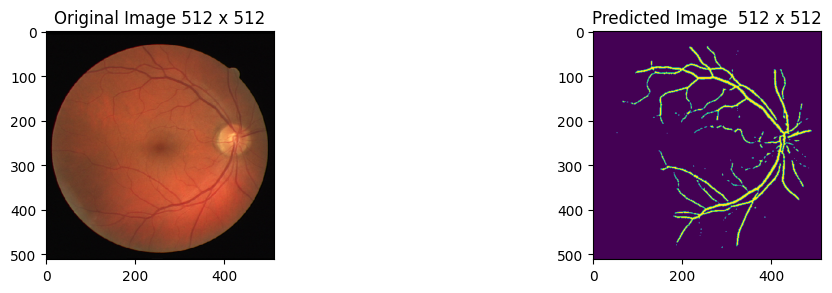

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


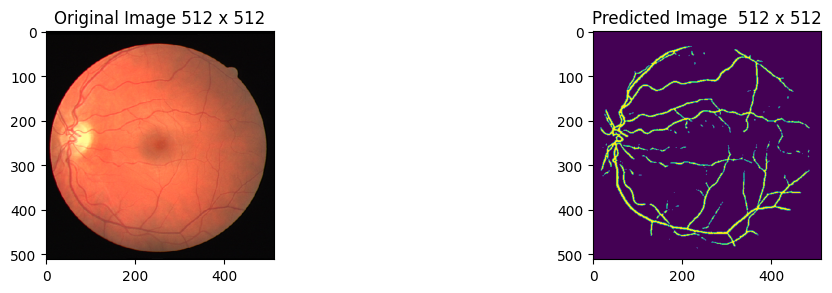

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


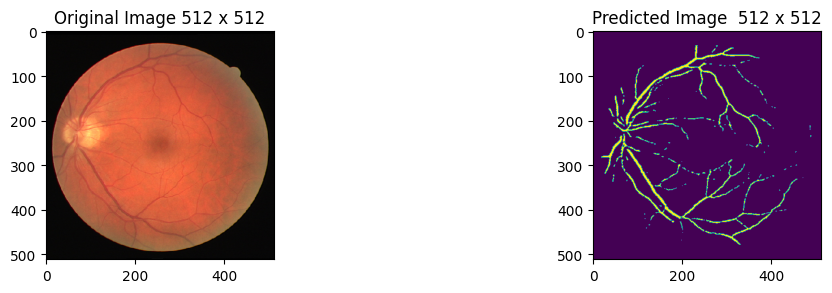

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


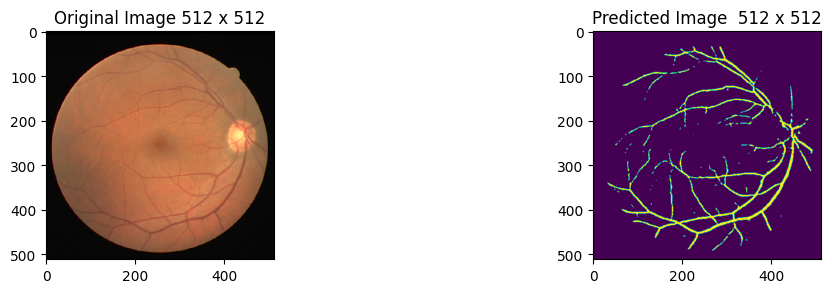

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


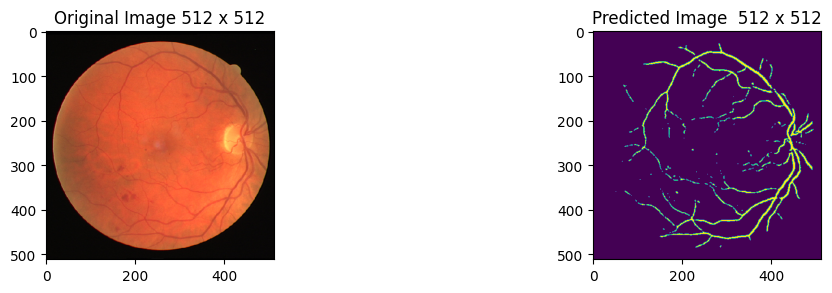

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


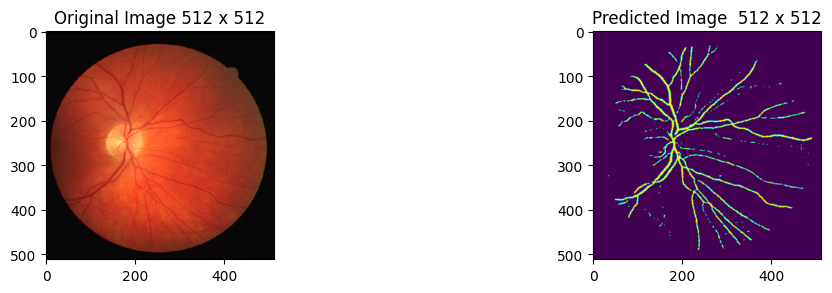

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


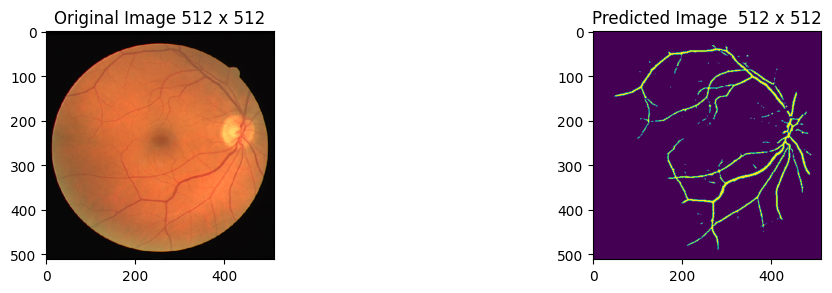

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


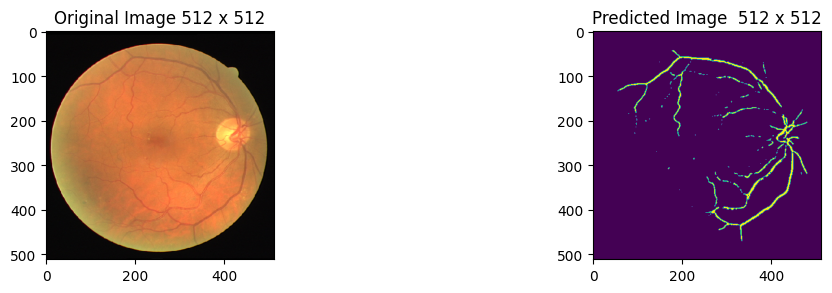

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


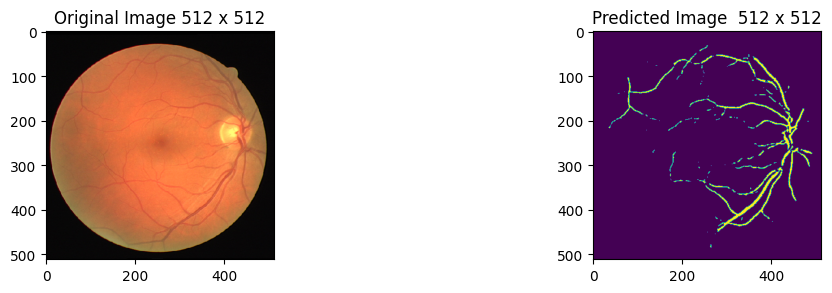

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


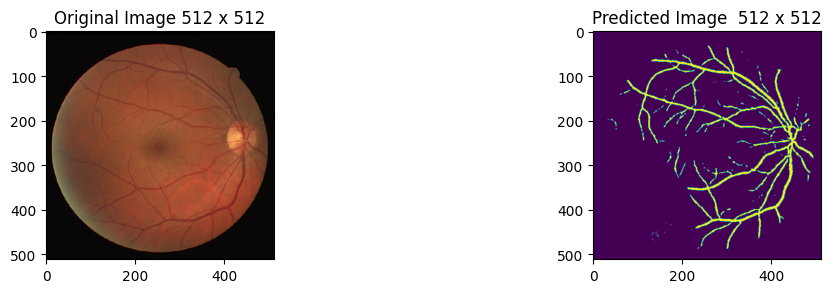

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


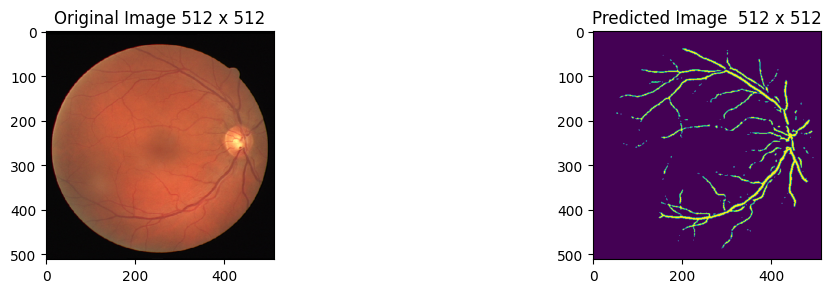

Id                                          Predicted
0    0  15621 2 16133 3 16617 2 16646 2 16674 2 17129 ...
1    1  16641 6 17155 6 17668 6 18182 4 18695 4 19208 ...
2    2  14092 2 15114 1 16133 3 16643 3 17153 4 17665 ...
3    3  14585 1 15097 3 16123 1 16635 3 17148 3 17662 ...
4    4  18722 2 19233 4 19745 4 20256 4 20767 5 21278 ...
5    5  18726 4 19239 5 19753 4 20167 4 20269 4 20679 ...
6    6  17129 4 17168 2 17641 5 17680 3 18154 5 18192 ...
7    7  16618 3 17130 5 17168 4 17642 6 17680 4 18155 ...
8    8  16148 2 16658 4 17169 5 17654 1 17680 5 18192 ...
9    9  17665 2 18138 2 18177 3 18649 6 18689 3 19161 ...
10  10  17622 9 18126 12 18634 12 19142 13 19651 14 20...
11  11  16615 5 16662 3 17127 5 17173 4 17639 4 17686 ...
12  12  17674 2 17694 1 18145 3 18186 3 18205 3 18657 ...
13  13  14619 3 15131 3 15643 3 16156 3 16594 2 16668 ...
14  14  17159 2 17630 1 17670 3 18141 3 18182 3 18200 ...
15  15  16652 5 17165 5 17679 4 18192 3 18218 4 18706 ...
16  16  22195 4 22706 6 23220 5 23733 5 24247 4 24760 ...
17  17  16641 2 17152 3 17664 2 18175 2 18685 4 19196 ...
18  18  17155 3 17667 4 18179 5 18692 4 18733 1 19204 ...
19  19  20170 8 20682 9 21195 10 21710 12 22223 13 223...

In [ ]:
def eval_one_epoch(dataloader, model):
    model.eval()
    outputs=[]
    for i, imgs in enumerate(dataloader):
        imgs=imgs.to(device)
        preds=model(imgs)

        with torch.no_grad():
            for i in range(preds.shape[0]):
                pred=preds[i,:,:,:]
                pred=torch.argmax(pred,dim=0).cpu()

                plotres(imgs[i],pred)

                predf=pred.flatten()

                pixelidx=np.where(predf==1)[0]+1

                run_lengths=[]

                for pxid in pixelidx:
                    if len(run_lengths)==0:
                        run_lengths.extend((pxid,1))
                    elif pxid>prev+1:
                        run_lengths.extend((pxid,1))
                    else:
                        run_lengths[-1]+=1
                    prev=pxid

                output = ' '.join([str(r) for r in run_lengths])

                outputs.append(output)
    return outputs

outputs=eval_one_epoch(test_dataloader,model)
df=pd.DataFrame(columns=['Id','Predicted'])
df['Id']=[str(i) for i in range(20)]
df['Predicted']=outputs
df.to_csv("submission.csv", index=None)
df